In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import seaborn as sns
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/IE313/DoAn/Data/wdi_pca_3.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Country,Country_code,PC1,PC2,PC3
0,Afghanistan,AFG,-4.440609,0.199704,-0.681927
1,Albania,ALB,1.384765,-1.001156,-0.291110
2,Algeria,DZA,1.394803,-1.304758,-0.833515
3,Andorra,AND,2.933966,1.703989,-0.540343
4,Angola,AGO,-3.776741,1.589128,1.606514


In [ ]:
df.shape

(192, 5)

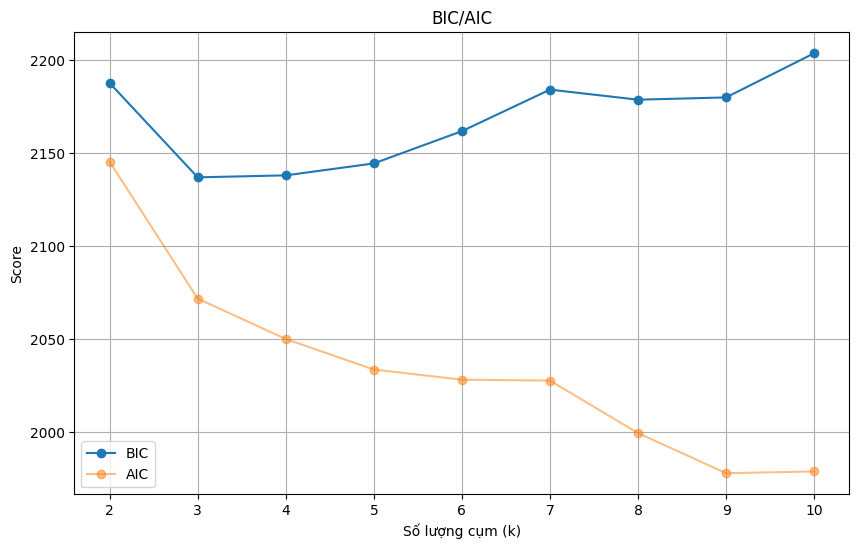

In [ ]:
# @title Tìm K tối ưu
X_pca = df.loc[:, 'PC1':'PC3']
n_components = range(2,11)
bics = []
aics = []

for n in n_components:
  gmm = GaussianMixture(n_components=n, covariance_type='diag', random_state=42)
  gmm.fit(X_pca)

  bics.append(gmm.bic(X_pca))
  aics.append(gmm.aic(X_pca))

# vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(n_components, bics, 'o-', label='BIC')
plt.plot(n_components, aics, 'o-', label='AIC', alpha=0.5)
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('Score')
plt.title('BIC/AIC')
plt.legend()
plt.grid(True)
plt.show()


Tiêu chí đánh giá lựa chọn số lượng cụm
* AIC: Phạt nhẹ hơn đối với mô hình phức tạp. Nó
có xu hướng gợi ý số lượng cụm nhiều hơn. Vì bộ dữ liệu có kích thước mẫu nhỏ (N < 200) nên AIC dễ bị Overfitting và phân ra nhiều cụm hơn chỉ vì vài nhiễu động nhỏ.
* BIC: Phạt nặng hơn dựa trên kích thước mẫu. Nó ưu tiên các mô hình đơn giản và gợi ý số cụm nhỏ.
* Kết luận: Ưu tiên BIC vì đáng tin cậy hơn và ít tạo ra nhiều cụm vặt.

covariance_type='diag'
* Mô hình sử dụng (covariance_type='diag') vì dữ liệu đã được PCA. PCA đã khử tương quan giữa các biến, khiến các PC trở nên độc lập tuyến tính. Ngoài ra, với kích thước mẫu nhỏ việc sử dụng 'diag' giúp giảm số lượng tham số cần ước lượng, tránh overfitting và giúp các cụm phân chia rõ ràng, ổn định hơn.

Chọn k=4
* Mặc dù chỉ số BIC đạt cực tiểu tại k=3 nhưng nhóm quyết định lựa chọn k=4 làm số cụm tối ưu. Quyết định này dựa trên việc giá trị BIC k=4 vẫn nằm trong ngưỡng thấp, đồng thời k=4 cung cấp khả năng giải thích về mặt kinh tế - xã hội.
* Cụ thể, kết quả phân cụm với k=4, các cụm được phân chia rõ rệt và ít bị chồng lấn. Các cụm được phân chia có sự tương đồng cao với phân loại 4 nhóm thu nhập của Ngân hàng Thế giới(World Bank).

In [ ]:
# @title GMM

k_optimal = 3
gmm = GaussianMixture(n_components=k_optimal, covariance_type='diag', random_state=42)

gmm.fit(X_pca)
cluster_labels = gmm.predict(X_pca)

proba = gmm.predict_proba(X_pca)

df['Cluster'] = cluster_labels

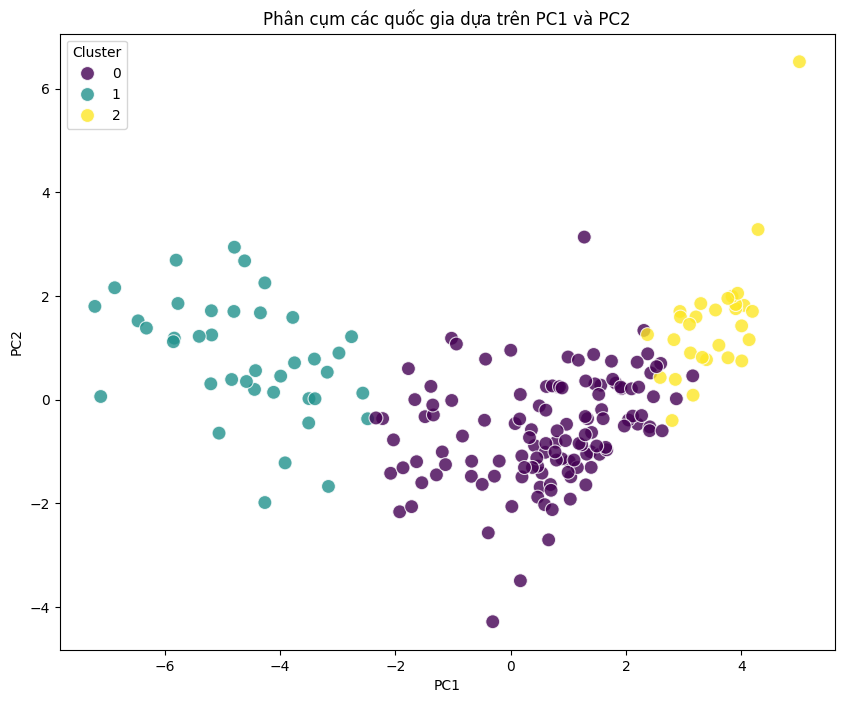

In [ ]:
plt.figure(figsize=(10,8))

sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.8)

plt.title('Phân cụm các quốc gia dựa trên PC1 và PC2')
plt.show()

In [ ]:
df.head()

,Country,Country_code,PC1,PC2,PC3,Cluster
0,Afghanistan,AFG,-4.440609,0.199704,-0.681927,1
1,Albania,ALB,1.384765,-1.001156,-0.291110,0
2,Algeria,DZA,1.394803,-1.304758,-0.833515,0
3,Andorra,AND,2.933966,1.703989,-0.540343,2
4,Angola,AGO,-3.776741,1.589128,1.606514,1


In [ ]:
# @title Đánh giá
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

labels = gmm.predict(X_pca)

sil_score = silhouette_score(X_pca, labels)
print("Silhouette Score:", sil_score)

db_score = davies_bouldin_score(X_pca, labels)
print("Davies-Bouldin Score:", db_score)

ch_score = calinski_harabasz_score(X_pca, labels)
print("Calinski-Harabasz Score:", ch_score)

Silhouette Score: 0.39325947280892376
Davies-Bouldin Score: 0.7573335941332738
Calinski-Harabasz Score: 192.32048230074912


In [ ]:
import plotly.express as px
df['Cluster'] = df['Cluster'].astype(str)

viridis_colors = {
    '0': '#f3722c', # Tím đậm
    '1': '#f94144', # Xanh dương
    '2': '#f9c74f', # Xanh lá
}

fig = px.choropleth(df,
                    locations="Country_code",
                    color="Cluster",
                    hover_name="Country",
                    color_continuous_scale="Viridis",
                    color_discrete_map=viridis_colors,
                    title="Phân bố các cụm quốc gia trên bản đồ thế giới",)
fig.show()

In [ ]:
df.to_csv('/content/drive/MyDrive/IE313/DoAn/Data/gmm_result.csv')